# 2019-1 Human & Computer Vision (MEDM422-01)
# Midterm report
# Fashion-MNIST Classification
# 120180047 박현근
---

- 사용 네트워크 모델 : resnet18
- 사용 gpu : 1070ti (8GB)
- 참고 github : [fashion-mnist](https://github.com/zalandoresearch/fashion-mnist), [random erasing](https://github.com/zhunzhong07/Random-Erasing)
- 실험 진행 과정 : batch size = 256, augmentation없이 20 epoch, 이어서 random erase 사용하여 20 epoch
- 결과 :  1) augmentation없이 전체 acc = 0.9508, 2)random erase 사용 전체 acc = 0.9513

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
from PIL import Image

In [3]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [4]:
class random_eraser(object):
    def __call__(self,img_):
        p=0.5
        s_l=0.02
        s_h=0.4
        r_1=0.3
        r_2=1/0.3
        v_l=0
        v_h=255
        #pixel_level=True

        img = np.array(img_)#img_ ipl image , img np array
        img_h, img_w = img.shape
        #img_c = 1
        p_1 = np.random.rand()

        if p_1 > p:
            tmp = Image.fromarray(img)
            return tmp

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        #if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w))
        #else:
        #    c = np.random.uniform(v_l, v_h)

        img[top:top + h, left:left + w] = c
        
        tmp = Image.fromarray(img)
        return tmp

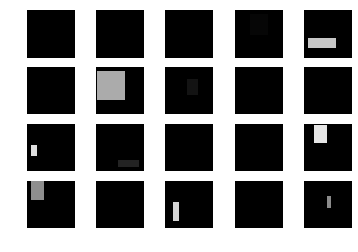

In [5]:
cols, rows = 5, 4
img_num = cols * rows

x = np.zeros((img_num, 64, 64,3), dtype=np.uint8)

eraser = get_random_eraser()

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(eraser(x[i]), interpolation="nearest")
    plt.axis('off')

re = random_eraser()

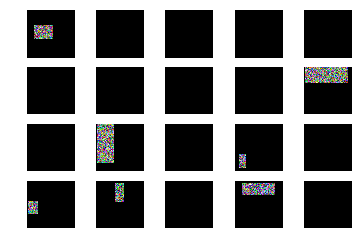

In [6]:
x = np.zeros((img_num, 64, 64, 3), dtype=np.uint8)

eraser = get_random_eraser(pixel_level=True)

for i in range(img_num):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(eraser(x[i]), interpolation="nearest")
    plt.axis('off')

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [8]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
rn_transform = transforms.Compose([transforms.Resize((224,224)),
                                   random_eraser(),
                                transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
rn_transform

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

In [11]:
train_fmnist = torchvision.datasets.FashionMNIST('./data',train=True,transform=transform)
test_fmnist = torchvision.datasets.FashionMNIST('./data/',train=False,transform=transform)

train2_fmnist = torchvision.datasets.FashionMNIST('./data',train=True,transform=rn_transform)

In [14]:
trainloader = torch.utils.data.DataLoader(train_fmnist, batch_size=256, shuffle=True)
testloader = torch.utils.data.DataLoader(test_fmnist, batch_size=256, shuffle=True)

train2loader = torch.utils.data.DataLoader(train2_fmnist, batch_size=256, shuffle=True)

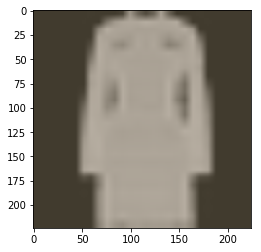

In [15]:
imshow(train_fmnist[500][0])

In [16]:
p=0.5
s_l=0.02
s_h=0.4
r_1=0.3
r_2=1/0.3
v_l=0
v_h=255


In [56]:
type(train_fmnist[500][0].numpy())
img.shape

(1, 224, 224)

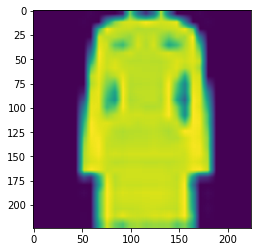

In [76]:
img = train_fmnist[500][0].numpy()[0,:,:]#tensor -> img np array
plt.imshow(img)
img_h, img_w = img.shape
#img_c = 1
p_1 = 0.45623274665#np.random.rand()

In [77]:
print(img_h,img_w,p_1)

224 224 0.45623274665


In [78]:
if p_1 > p:
    img = img
else :
    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break
    c = np.random.uniform(v_l, v_h, (h, w))
    img[top:top + h, left:left + w] = c

In [79]:
print(c.shape)
print(img.shape)
print(type(img))
tmp = Image.fromarray(img)
print(type(tmp))

(125, 75)
(224, 224)
<class 'numpy.ndarray'>
<class 'PIL.Image.Image'>


In [25]:
print(train_fmnist)
print(test_fmnist)
print(trainloader)
print(testloader)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data/
    Transforms (if any): Compose(
                             Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [26]:
image_datasets = {'train': train_fmnist,'val': test_fmnist,'train2':train2_fmnist}

In [27]:
image_datasets

{'train': Dataset FashionMNIST
     Number of datapoints: 60000
     Split: train
     Root Location: ./data
     Transforms (if any): Compose(
                              Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                              ToTensor()
                              Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                          )
     Target Transforms (if any): None, 'val': Dataset FashionMNIST
     Number of datapoints: 10000
     Split: test
     Root Location: ./data/
     Transforms (if any): Compose(
                              Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
                              ToTensor()
                              Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                          )
     Target Transforms (if any): None, 'train2': Dataset FashionMNIST
     Number of datapoints: 60000
     Split: train
     Root Location: ./data
     Transforms (if any): Compose(
             

In [28]:
dataloaders = {'train': trainloader,'val': testloader,'train2':train2loader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','train2']}

In [29]:
#labels_name = [[0,'tshirt'],[1,'trouser'],[2,'pullover'],[3,'dress'],[4,'coat']
#              ,[5,'sandal'],[6,'shirt'],[7,'sneaker'],[8,'bag'],[9,'ankle boot']]

labels_name = ['tshirt','trouser','pullover','dress','coat',
               'sandal','shirt','sneaker','bag','ankle boot']

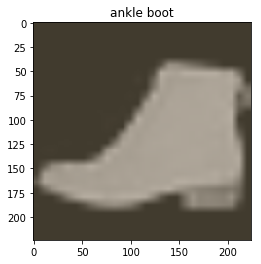

In [30]:
imshow(train_fmnist[7000][0],title=labels_name[train_fmnist[7000][1]])

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

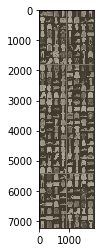

In [32]:
inputs, classes = next(iter(trainloader))
out = torchvision.utils.make_grid(inputs)

imshow(out)
#imshow(out,title=[labels_name[x] for x in classes])

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
        
    best_state_path = './last_best_checkpoint.pth'
    exists = os.path.isfile(best_state_path)
    if exists:
        checkpoint = torch.load(best_state_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = checkpoint['best_acc']
    else:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
           

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #kk = 0
            class_corrects = np.array([0,0,0,0,0,
                                       0,0,0,0,0])

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                #print(preds,labels.data)
                #print(preds.shape)
                #print(preds)
                #print(preds==labels.data)
                #print(preds[preds==labels.data])
                
                class_corrects_arr = preds[preds==labels.data]
                
                for i in class_corrects_arr:
                    class_corrects[i] += 1
                #print('Running loss {}: {:.4f}'.format(kk,running_loss))
                #kk += 1 

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_class_acc = class_corrects*10 / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                for x in range(10):
                    print('{} Acc: {:.4f}'.format(labels_name[x],epoch_class_acc[x]) )
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch': epoch,
                            'model_state_dict': best_model_wts,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': epoch_loss,
                            'best_acc': best_acc
                            },best_state_path)
            print('------------------------------------------')
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [49]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, label:{}'.format(labels_name[preds[j]],labels_name[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [41]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft.conv1 = nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(),lr =0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [42]:
model_ft

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [43]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/99
----------
train Loss: 0.2951 Acc: 0.8933
------------------------------------------
val Loss: 0.2326 Acc: 0.9156
tshirt Acc: 0.8270
trouser Acc: 0.9800
pullover Acc: 0.8960
dress Acc: 0.9410
coat Acc: 0.8860
sandal Acc: 0.9860
shirt Acc: 0.7460
sneaker Acc: 0.9880
bag Acc: 0.9860
ankle boot Acc: 0.9200
------------------------------------------
Epoch 1/99
----------
train Loss: 0.1846 Acc: 0.9330
------------------------------------------
val Loss: 0.2163 Acc: 0.9227
tshirt Acc: 0.8780
trouser Acc: 0.9720
pullover Acc: 0.8420
dress Acc: 0.8860
coat Acc: 0.9590
sandal Acc: 0.9770
shirt Acc: 0.7700
sneaker Acc: 0.9810
bag Acc: 0.9910
ankle boot Acc: 0.9710
------------------------------------------
Epoch 2/99
----------
train Loss: 0.1473 Acc: 0.9470
------------------------------------------
val Loss: 0.2217 Acc: 0.9202
------------------------------------------
Epoch 3/99
----------
train Loss: 0.1222 Acc: 0.9547
------------------------------------------
val Loss: 0.1960 A

KeyboardInterrupt: 

In [46]:
def train2_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
        
    best_state_path = './last_best_checkpoint.pth'
    exists = os.path.isfile(best_state_path)
    if exists:
        checkpoint = torch.load(best_state_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = checkpoint['best_acc']
        print('last best acc:{}'.format(best_acc))
    else:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
           

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train2', 'val']:
            if phase == 'train2':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #kk = 0
            class_corrects = np.array([0,0,0,0,0,
                                       0,0,0,0,0])

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train2'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train2':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                #print(preds,labels.data)
                #print(preds.shape)
                #print(preds)
                #print(preds==labels.data)
                #print(preds[preds==labels.data])
                
                class_corrects_arr = preds[preds==labels.data]
                
                for i in class_corrects_arr:
                    class_corrects[i] += 1
                #print('Running loss {}: {:.4f}'.format(kk,running_loss))
                #kk += 1 

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_class_acc = class_corrects*10 / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                for x in range(10):
                    print('{} Acc: {:.4f}'.format(labels_name[x],epoch_class_acc[x]) )
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch': epoch,
                            'model_state_dict': best_model_wts,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': epoch_loss,
                            'best_acc': best_acc
                            },best_state_path)
            print('------------------------------------------')
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [47]:
optimizer_ft = optim.Adam(model_ft.parameters(),lr =0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [48]:
model_ft = train2_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

last best acc:0.9508000000000001
Epoch 0/19
----------
train2 Loss: 0.1340 Acc: 0.9508
------------------------------------------
val Loss: 0.2325 Acc: 0.9270
------------------------------------------
Epoch 1/19
----------
train2 Loss: 0.0864 Acc: 0.9683
------------------------------------------
val Loss: 0.2226 Acc: 0.9343
------------------------------------------
Epoch 2/19
----------
train2 Loss: 0.0666 Acc: 0.9757
------------------------------------------
val Loss: 0.2564 Acc: 0.9327
------------------------------------------
Epoch 3/19
----------
train2 Loss: 0.0561 Acc: 0.9796
------------------------------------------
val Loss: 0.2870 Acc: 0.9297
------------------------------------------
Epoch 4/19
----------
train2 Loss: 0.0434 Acc: 0.9850
------------------------------------------
val Loss: 0.2580 Acc: 0.9387
------------------------------------------
Epoch 5/19
----------
train2 Loss: 0.0397 Acc: 0.9857
------------------------------------------
val Loss: 0.2679 Acc: 0.9

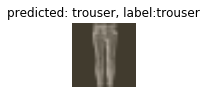

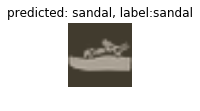

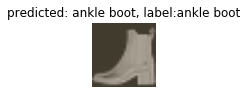

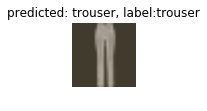

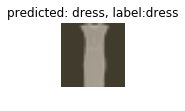

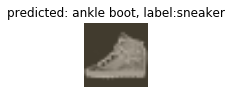

In [50]:
visualize_model(model_ft)